# Loading libraries

In [13]:
import glob2 as glob
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

import pandas as pd
pd.option_context("display.max_columns", None)

# Loading data

We took several amount of experiments in different locations and those are considered as datasets for training.

In [14]:
path= '/content/drive/MyDrive/Research/IBM Advanced Data Science/'

In [15]:
testDF = pd.read_csv(path + 'test_DF.csv')
testDF.head()

,Sr No,Timestamp,Device Name,MAC Address,RSSI,Raw Data,Battery,Ambient Temperature,user_at,file_id,beacon_at,Timestamp2
0,2,2021-08-17 06:39:39.918,BrtBeacon402,C2:65:7C:E2:D6:6B,-59,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000
1,5,2021-08-17 06:39:39.967,BMPkitchen,80:EC:CA:CD:2F:42,-81,1a4c0002150112233445566778899aabbccddeeff02716...,-,-,study,1,kitchen,2021-08-17 06:39:40.000
2,7,2021-08-17 06:39:40.027,BrtBeacon402,C2:65:7C:E2:D6:6B,-59,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000
3,8,2021-08-17 06:39:40.059,BrtBeacon402,D9:C7:16:15:A3:0F,-94,-,21,170.1 Deg C,study,1,living,2021-08-17 06:39:40.000
4,11,2021-08-17 06:39:40.131,BrtBeacon402,C2:65:7C:E2:D6:6B,-57,-,21,170.1 Deg C,study,1,study,2021-08-17 06:39:40.000


Changing shape of dataframe

In [16]:
#testDF_pv = testDF.pivot_table(values='RSSI', columns = 'beacon_at', index=['Timestamp2', 'user_at', 'file_id'], aggfunc = max)
testDF_pv = testDF.pivot_table(values='RSSI', columns = 'beacon_at', index=['Timestamp2', 'user_at', 'file_id'], aggfunc = 'median')
testDF_pv = testDF_pv.reset_index()
testDF_pv

beacon_at,Timestamp2,user_at,file_id,kitchen,living,main,study
0,2021-08-17 06:15:45.000,main,2,NaN,-76.0,-64.0,-74.5
1,2021-08-17 06:15:45.500,main,2,-86.0,-74.5,NaN,-72.0
2,2021-08-17 06:15:46.000,main,2,NaN,-72.0,NaN,-75.0
3,2021-08-17 06:15:46.500,main,2,-89.0,-70.0,-60.0,-70.0
4,2021-08-17 06:15:47.000,main,2,NaN,-70.0,-61.0,-70.0
...,...,...,...,...,...,...,...
2654,2021-08-23 11:44:24.500,living,30,-80.5,-61.5,-74.0,-80.0
2655,2021-08-23 11:44:25.000,living,30,-79.5,-61.5,-76.0,-79.0
2656,2021-08-23 11:44:25.500,living,30,-78.0,-62.0,-77.0,-79.0
2657,2021-08-23 11:44:26.000,living,30,-76.5,-62.0,-76.0,-79.0


## Feature creation

Change missing values based on median of each 'user_at'.

In [17]:
final=testDF_pv.copy()

final["kitchen"] = final['kitchen'].fillna(final.groupby('user_at')['kitchen'].transform('median'))
final["living"] = final['living'].fillna(final.groupby('user_at')['living'].transform('median'))
final["main"] = final['main'].fillna(final.groupby('user_at')['main'].transform('median'))
final["study"] = final['study'].fillna(final.groupby('user_at')['study'].transform('median'))

final.sort_values(by=['file_id', 'Timestamp2'], inplace=True)
final.reset_index(drop=True, inplace=True)
final = final.rename_axis(None, axis=1)
final['id'] = final.groupby('file_id')['file_id'].rank(method='first')
final

,Timestamp2,user_at,file_id,kitchen,living,main,study,id
0,2021-08-17 06:39:40.000,study,1,-81.0,-94.0,-76.0,-58.0,1.0
1,2021-08-17 06:39:40.500,study,1,-81.0,-83.0,-73.0,-60.0,2.0
2,2021-08-17 06:39:45.000,study,1,-76.0,-79.0,-73.0,-51.0,3.0
3,2021-08-17 06:39:45.500,study,1,-82.0,-83.0,-84.0,-53.5,4.0
4,2021-08-17 06:39:46.000,study,1,-72.0,-83.0,-78.0,-50.0,5.0
...,...,...,...,...,...,...,...,...
2654,2021-08-23 11:44:24.500,living,30,-80.5,-61.5,-74.0,-80.0,80.0
2655,2021-08-23 11:44:25.000,living,30,-79.5,-61.5,-76.0,-79.0,81.0
2656,2021-08-23 11:44:25.500,living,30,-78.0,-62.0,-77.0,-79.0,82.0
2657,2021-08-23 11:44:26.000,living,30,-76.5,-62.0,-76.0,-79.0,83.0


Creating a new dataframe with the fixed information from RSSIs and no missing values.

In [18]:
final_clean = final[['Timestamp2', 'user_at', 'file_id', 'id']].copy()
final_clean[['kitchen', 'living', 'main', 'study']] = 0
final_clean.tail()

,Timestamp2,user_at,file_id,id,kitchen,living,main,study
2654,2021-08-23 11:44:24.500,living,30,80.0,0,0,0,0
2655,2021-08-23 11:44:25.000,living,30,81.0,0,0,0,0
2656,2021-08-23 11:44:25.500,living,30,82.0,0,0,0,0
2657,2021-08-23 11:44:26.000,living,30,83.0,0,0,0,0
2658,2021-08-23 11:44:26.500,living,30,84.0,0,0,0,0


In [19]:
ba = testDF['beacon_at'].unique().tolist()
fi = final['file_id'].unique().tolist()

for beacon in ba:
  for file in fi:
    tmp = final.loc[final['file_id']==file, ['id', beacon]]
    res = sm.nonparametric.lowess(tmp.iloc[:,1], tmp.iloc[:,0], frac = 1./2)
    res_loess = list(res[:,1])
    final_clean.loc[tmp.index, beacon] = res_loess

In [20]:
final.tail(10)

,Timestamp2,user_at,file_id,kitchen,living,main,study,id
2649,2021-08-23 11:44:22.000,living,30,-76.0,-63.0,-72.0,-75.5,75.0
2650,2021-08-23 11:44:22.500,living,30,-76.0,-61.0,-72.0,-76.0,76.0
2651,2021-08-23 11:44:23.000,living,30,-80.0,-60.5,-76.0,-80.0,77.0
2652,2021-08-23 11:44:23.500,living,30,-80.0,-60.0,-76.0,-80.0,78.0
2653,2021-08-23 11:44:24.000,living,30,-80.0,-61.0,-73.5,-80.0,79.0
2654,2021-08-23 11:44:24.500,living,30,-80.5,-61.5,-74.0,-80.0,80.0
2655,2021-08-23 11:44:25.000,living,30,-79.5,-61.5,-76.0,-79.0,81.0
2656,2021-08-23 11:44:25.500,living,30,-78.0,-62.0,-77.0,-79.0,82.0
2657,2021-08-23 11:44:26.000,living,30,-76.5,-62.0,-76.0,-79.0,83.0
2658,2021-08-23 11:44:26.500,living,30,-76.0,-61.5,-76.0,-78.0,84.0


In [21]:
final_clean.tail(10)

,Timestamp2,user_at,file_id,id,kitchen,living,main,study
2649,2021-08-23 11:44:22.000,living,30,75.0,-76.339730,-62.946464,-74.603554,-78.401215
2650,2021-08-23 11:44:22.500,living,30,76.0,-76.534996,-62.835735,-74.583311,-78.301773
2651,2021-08-23 11:44:23.000,living,30,77.0,-76.737235,-62.719334,-74.561626,-78.205859
2652,2021-08-23 11:44:23.500,living,30,78.0,-76.946492,-62.597221,-74.539405,-78.114218
2653,2021-08-23 11:44:24.000,living,30,79.0,-77.162596,-62.469515,-74.517424,-78.027403
2654,2021-08-23 11:44:24.500,living,30,80.0,-77.385166,-62.336479,-74.496332,-77.945767
2655,2021-08-23 11:44:25.000,living,30,81.0,-77.613651,-62.198465,-74.476745,-77.869481
2656,2021-08-23 11:44:25.500,living,30,82.0,-77.847349,-62.055868,-74.459230,-77.798562
2657,2021-08-23 11:44:26.000,living,30,83.0,-78.085483,-61.909105,-74.444212,-77.732918
2658,2021-08-23 11:44:26.500,living,30,84.0,-78.327313,-61.758574,-74.431933,-77.672364


In [22]:
final_clean[['user_at', 'file_id']].drop_duplicates().head()

,user_at,file_id
0,study,1
53,main,2
111,living,3
220,kitchen,4
270,study,5


Let's check how the denoise worked.

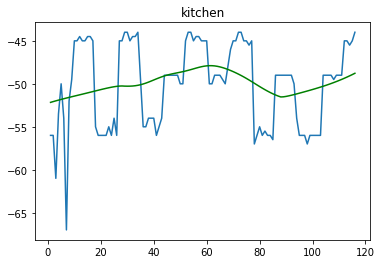

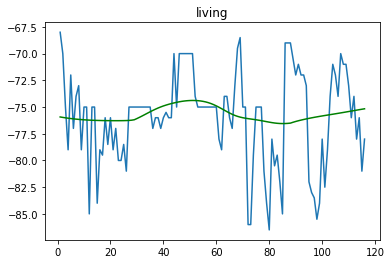

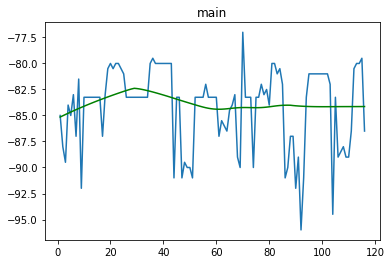

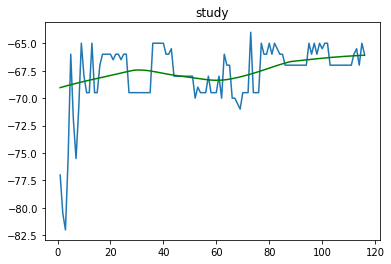

In [23]:
file_n = 26
tmpDf0 = final[(final['file_id']==file_n)]
tmpDf1 = final_clean[(final_clean['file_id']==file_n)]

plt.plot(tmpDf0['id'], tmpDf0['kitchen'])
plt.plot(tmpDf0['id'], tmpDf1['kitchen'], color='green')
plt.title('kitchen')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['living'])
plt.plot(tmpDf0['id'], tmpDf1['living'], color='green')
plt.title('living')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['main'])
plt.plot(tmpDf0['id'], tmpDf1['main'], color='green')
plt.title('main')
plt.show()

plt.plot(tmpDf0['id'], tmpDf0['study'])
plt.plot(tmpDf0['id'], tmpDf1['study'], color='green')
plt.title('study')
plt.show()



In [24]:
final_clean.to_csv(path + 'final_clean_test.csv', index=False)